# Google Gemini

This notebook covers setup, authentication, text generation, conversations, streaming, and handling different content types.

## What are Large Language Models (LLMs)?

**Large Language Models** are deep neural networks trained on vast amounts of text data to understand and generate human-like language. They learn statistical patterns, relationships, and structures in language through a process called **unsupervised learning**.

### Key Concepts in Language Modeling:

1. **Token-based Processing**: Text is broken into tokens (words, subwords, or characters), and the model learns to predict the next token given previous context.

2. **Transformers Architecture**: Modern LLMs use the transformer architecture, which employs attention mechanisms to understand relationships between tokens, regardless of their distance in text.

3. **Pre-training and Fine-tuning**: Models are first pre-trained on massive datasets, then fine-tuned for specific tasks or aligned with human preferences.

4. **Autoregressive Generation**: LLMs generate text one token at a time, using previously generated tokens as context for the next prediction.

Google Gemini represents the latest generation of multimodal LLMs, capable of understanding and generating not just text, but also images, audio, and video.

## 1. Install and Import Required Libraries

First, we'll install the Google GenAI SDK and import necessary libraries.

The latest recommended package is `google-genai` which is the official Google AI SDK for accessing Gemini models.

In [1]:
# Install the Google GenAI SDK
# Uncomment the line below to install (if not already installed)
# !pip install -q -U google-genai

# Import required libraries
import os
import json
from google import genai

## 2. Set Up API Authentication

### Authentication in API-based LLMs

The Gemini API uses **API key authentication** to identify and authorize your requests. API keys serve multiple purposes:

1. **Identity Verification**: Confirms you're an authorized user
2. **Usage Tracking**: Monitors your API calls for billing and rate limiting
3. **Security**: Prevents unauthorized access to the service
4. **Resource Allocation**: Manages quotas and priorities

**Best Practices for API Key Security:**
- Store keys in environment variables, never hardcode them
- Use `.env` files for local development (add to `.gitignore`)
- Rotate keys periodically
- Use separate keys for development, testing, and production
- Revoke compromised keys immediately

### Getting Your Google Gemini API Key

Follow these steps to obtain your free API key:

**Step 1**: Go to Google AI Studio  
https://aistudio.google.com/app/api-keys

**Step 2**: Click on "Create API Key"  
<img src="../assets/gem1.png" width="250" alt="Create API Key button"/>

**Step 3**: Choose an arbitrary name and click "Create Key"  
<img src="../assets/gem2.png" width="250" alt="Name your API key"/>

**Step 4**: Copy your key securely  
<img src="../assets/gem3.png" width="250" alt="Copy API key"/>

⚠️ **Important**: Treat your API key like a password. Never share it or commit it to version control.

### Setting Up Authentication

There are two methods to authenticate with the Gemini API:

**Method 1 (Recommended)**: Use environment variables
```bash
export GEMINI_API_KEY='your-api-key-here'
```

**Method 2 (For Testing Only)**: Pass the key directly to the client (shown in next cell for demonstration purposes)

In [ ]:
# Method 1: Using environment variable (Recommended)
# The client automatically picks up GEMINI_API_KEY from environment
# api_key = os.getenv("GEMINI_API_KEY")
api_key = ""

if not api_key:
    # Try alternate environment variable name
    api_key = os.getenv("GEMINI")

if api_key:
    print(f"API Key found!")
    # Initialize the client - it will use the API key automatically
    client = genai.Client(api_key=api_key)
else:
    print("Warning: GEMINI_API_KEY or GEMINI environment variable not found!")
    print("Set it before proceeding: export GEMINI_API_KEY='your-api-key'")
    client = None

API Key found!


In [3]:
client

## 3. Available Gemini Models

Let's explore the available models and their capabilities.

In [4]:

# List available models
models_pager = client.models.list()

print("Available Gemini Models:\n")
print(f"{'Model Name':<40} {'Description':<50}")
print("-" * 90)

count = 0
for model in models_pager:  # Iterate through pager
    
    model_name = model.name.split('/')[-1]
    # Get description if available
    desc = "Text Generation Model"
    if "vision" in model.display_name.lower():
        desc = "Multimodal Model (Text, Image)"
    elif "flash" in model.display_name.lower():
        desc = "Fast, Efficient Model"
    
    print(f"{model_name:<40} {desc:<50}")
    count += 1


Available Gemini Models:

Model Name                               Description                                       
------------------------------------------------------------------------------------------
embedding-gecko-001                      Text Generation Model                             
gemini-2.5-flash                         Fast, Efficient Model                             
gemini-2.5-pro                           Text Generation Model                             
gemini-2.0-flash-exp                     Fast, Efficient Model                             
gemini-2.0-flash                         Fast, Efficient Model                             
gemini-2.0-flash-001                     Fast, Efficient Model                             
gemini-2.0-flash-exp-image-generation    Fast, Efficient Model                             
gemini-2.0-flash-lite-001                Fast, Efficient Model                             
gemini-2.0-flash-lite                    Fast, Efficien

### 3.1 Available Gemini Models (Based on Your API Access)

The cell above shows the models currently available in your account. Here's a breakdown of the main models you have access to:

| Model Name | Type | Best Use Case |
|------------|------|---------------|
| **gemini-3-pro-preview** | Preview/Experimental | Latest Gemini 3.0 Pro - complex reasoning, analysis |
| **gemini-3-flash-preview** | Preview/Experimental | Latest Gemini 3.0 Flash - fast, efficient, high-volume tasks |
| **gemini-3-pro-image-preview** | Multimodal Preview | Image generation and understanding |
| **gemma-3-27b-it** | Open Model | Instruction-tuned Gemma model (27B parameters) |
| **deep-research-pro-preview-12-2025** | Specialized | Advanced research and analysis tasks |

### Model Naming Convention:

- **Preview/Experimental** models: Latest features, may change before stable release
- **Flash** variants: Optimized for speed and cost-effectiveness
- **Pro** variants: Balanced performance for complex tasks
- **Image** variants: Support multimodal input/output (images + text)
- **Deep Research**: Specialized for in-depth analysis and research tasks
- **Gemma**: Google's open-source model family (different from Gemini)

### Choosing the Right Model:

1. **Fast responses & high volume** → Use `gemini-3-flash-preview`
2. **Complex reasoning & analysis** → Use `gemini-3-pro-preview`
3. **Image generation/understanding** → Use `gemini-3-pro-image-preview`
4. **Research tasks** → Use `deep-research-pro-preview-12-2025`
5. **Open-source option** → Use `gemma-3-27b-it`

**Important**: Preview models may change or be deprecated. Check the official documentation for the latest stable releases.

**Resources:**
- **Rate Limits**: https://ai.google.dev/gemini-api/docs/rate-limits  
- **Pricing**: https://ai.google.dev/gemini-api/docs/pricing
- **Model Documentation**: https://ai.google.dev/gemini-api/docs/models

## 4. Generate Text Responses

The most basic use of the Gemini API: sending a prompt and getting a text response.

### Language Modeling Fundamentals: Text Generation

At its core, **text generation** is the process of predicting the next token given a sequence of previous tokens. This is formalized as:

$$P(w_t | w_1, w_2, ..., w_{t-1})$$

Where $w_t$ is the token at position $t$, and the model computes the probability distribution over all possible next tokens.

**Key Parameters in Generation:**

1. **Temperature** ($\tau$): Controls randomness in token selection. Lower values make the model more deterministic.
   $$P_i = \frac{\exp(z_i / \tau)}{\sum_j \exp(z_j / \tau)}$$

2. **Top-k Sampling**: Limits selection to the k most probable tokens, preventing unlikely options.

3. **Top-p (Nucleus) Sampling**: Selects from the smallest set of tokens whose cumulative probability exceeds p.

Let's see this in action with a simple text generation example:

In [5]:

model = "gemini-3-flash-preview"  # Using the latest efficient model
    
prompt = "Explain quantum computing in 2-3 sentences for someone who is new to the topic."
    
print(f"Model: {model}")
print(f"Prompt: {prompt}\n")
print("Response:")
print("-" * 50)

response = client.models.generate_content(
    model=model,
    contents=prompt
)

parts = response.candidates[0].content.parts

text_out = "".join(p.text for p in parts if getattr(p, "text", None))
print(text_out)

Model: gemini-3-flash-preview
Prompt: Explain quantum computing in 2-3 sentences for someone who is new to the topic.

Response:
--------------------------------------------------
Quantum computing uses the principles of quantum physics to process information much more efficiently than the computers we use today. Instead of using bits that are either a 0 or a 1, quantum computers use "qubits" that can represent both states at the same time, allowing them to explore many solutions to a problem simultaneously. This unique capability enables them to solve complex calculations that would take traditional supercomputers thousands of years to complete.


### 4.1 Generation Parameters

You can customize the model's behavior using generation parameters.

### Language Modeling: Controlling Generation with Parameters

The way an LLM generates text can be dramatically influenced by **generation parameters**. Understanding these parameters is crucial for controlling the model's creativity, coherence, and reliability.

**Temperature**: Think of temperature as a "creativity knob"
- Low temperature (0.0-0.3): Deterministic, focused on most likely tokens → Good for factual tasks
- Medium temperature (0.4-0.7): Balanced creativity → Good for general conversation
- High temperature (0.8-1.0+): More random, exploratory → Good for creative writing

**Top-k Sampling**: Restricts the model to choosing from only the k most likely next tokens. This prevents the model from selecting improbable words while maintaining diversity.

**Top-p (Nucleus) Sampling**: Dynamically adjusts the number of tokens considered by selecting from the smallest set whose cumulative probability exceeds p. This is often more effective than top-k.

**Max Output Tokens**: Limits the length of the response, helping to control costs and response time.

Let's experiment with different parameters:

In [7]:
from google.genai import types

model = "gemini-2.5-flash"  # Using a cheaper yet fast model
model = "gemini-3-flash-preview"  # Using the latest efficient model

# Using generation configuration to customize behavior
gen_config = types.GenerateContentConfig(
    temperature=0.7,  # 0.0 = deterministic, 1.0 = more random
    # top_p=0.95,       # Nucleus sampling parameter
    top_k=40,         # Top K sampling parameter
    max_output_tokens=512,  # Limit output length
)

prompt = "Write a creative poem about artificial intelligence."

response = client.models.generate_content(
    model=model,
    contents=prompt,
    config=gen_config
)

print("Response:")
print(response.text)

Response:
In a cradle of silicon and copper-spun veins,
Where the pulse is a current


## 5. Use System Instructions

System instructions allow you to set the model's behavior, tone, and constraints for all requests in a conversation.

### Language Modeling: System Instructions as Context Priming

**System instructions** are a powerful technique in modern LLMs that leverages the concept of **prompt engineering** and **in-context learning**.

**How It Works:**
- System instructions are prepended to every user message in the conversation
- They set the "persona" or "role" of the model, constraining its behavior
- The model uses this context to adjust its response style, tone, and content

**Why It Matters:**
In transformer models, the attention mechanism allows the model to reference the system instruction when generating each token. This creates a form of **soft conditioning** where the instruction guides generation without explicit fine-tuning.

**Best Practices for System Instructions:**
1. Be specific and clear about the desired behavior
2. Include formatting requirements if needed
3. Specify constraints (e.g., language level, tone, length)
4. Define what the model should and shouldn't do

System instructions are especially useful for:
- Role-playing scenarios (tutors, assistants, experts)
- Consistent formatting of outputs
- Domain-specific behavior
- Safety and content filtering

In [10]:
from google.genai import types

model = "gemini-2.5-flash"
model = "gemini-3-flash-preview"

# Define system instructions to control model behavior
system_instruction = """You are a helpful Python programming tutor. 
- Provide clear, beginner-friendly explanations
- Always include code examples
- Encourage questions and practice
- Use simple language, avoid jargon"""

prompt = "How do I read a file in Python?"

response = client.models.generate_content(
    model=model,
    contents=prompt,
    config=types.GenerateContentConfig(
        system_instruction=system_instruction,
        max_output_tokens=512,
    )
)

print("System Instruction Set: Python Programming Tutor")
print(f"Prompt: {prompt}\n")
print("Response:")
print(response.text)


System Instruction Set: Python Programming Tutor
Prompt: How do I read a file in Python?

Response:
Hello! I'd be happy to help you with that. Reading files is a very common task in Python, and luckily, Python makes it quite easy.

### The Best Way: The `with` Statement

The most common and safest way to read a file is using the **`with` statement**. This is great because it automatically closes the file for you once you are finished, which prevents memory leaks or errors.

Here is the basic structure:

```python
# 'example.txt' is the name of your file
# 'r' stands for 'read' mode
with open('example.txt', 'r') as my_file:
    content = my_file.read()
    print(content)
```

### 3 Different Ways to Read Content

Depending on what you need, there are different methods you can use inside that `with


## 6. Multi-turn Conversations

Use the ChatSession class to build interactive conversations that maintain context across multiple turns.

### Language Modeling: Context Windows and Conversation History

Multi-turn conversations demonstrate a critical concept in LLMs: **context maintenance** and the **attention mechanism**.

**Context Window**: The maximum number of tokens (both input and output) that a model can consider at once. Gemini models have context windows ranging from 1M to 2M tokens.

**How Conversations Work:**
1. Each message (user and assistant) is stored in the conversation history
2. When generating a response, the model attends to all previous messages
3. The **self-attention mechanism** computes relevance scores between the current token being generated and all previous tokens
4. This allows the model to maintain coherence across multiple turns

**Mathematical Foundation:**
For each position in the sequence, attention is computed as:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where Q (query), K (key), and V (value) are learned projections of the input embeddings.

**Challenges:**
- **Context length limitations**: Older models could only handle short conversations
- **Attention complexity**: Grows quadratically with sequence length ($O(n^2)$)
- **Context management**: Deciding what to keep when approaching limits

Let's see how the model maintains context across multiple conversation turns:

In [ ]:
# model = "gemini-2.5-flash"
model = "gemini-3-flash-preview"

# Create a chat session with system instructions
chat_config = types.GenerateContentConfig(
    system_instruction="You are a friendly and knowledgeable assistant about machine learning.",
    temperature=0.7,
    max_output_tokens=500
)

# Initialize chat session
chat = client.chats.create(
    model=model,
    config=chat_config
)

try:
    # First turn
    message1 = "What is machine learning?"
    print(f"User: {message1}")
    response1 = chat.send_message(message1)
    print(f"Assistant: {response1.text}\n")
    
    # Second turn - context is maintained
    message2 = "Can you give me a practical example?"
    print(f"User: {message2}")
    response2 = chat.send_message(message2)
    print(f"Assistant: {response2.text}\n")
    
    # Third turn
    message3 = "How would you apply this to predicting house prices?"
    print(f"User: {message3}")
    response3 = chat.send_message(message3)
    print(f"Assistant: {response3.text}")
    
except Exception as e:
    print(f"⚠ Chat error: {str(e)[:150]}")
    print("\nNote: Chat sessions may hit rate limits. Here's how multi-turn conversations work:")
    print("\n1. Create a chat session with a config")
    print("2. Send messages using chat.send_message(message)")
    print("3. The model maintains context automatically across turns")
    print("4. Each response is based on the entire conversation history")
    
    # Demonstrate the concept without live API calls
    print("\n--- Conversation Example (Conceptual) ---")
    print("User: What is machine learning?")
    print("Assistant: [First response about ML definition]")
    print("\nUser: Can you give me a practical example?")
    print("Assistant: [Second response uses context from first turn]")
    print("\nUser: How would you apply this to predicting house prices?")
    print("Assistant: [Third response builds on conversation context]")


User: What is machine learning?
Assistant: That's a fantastic question! Machine learning (ML) is a fascinating and rapidly evolving

User: Can you give me a practical example?
Assistant: Absolutely! Let's use a very common and practical example: **Email Spam Detection**.

Imagine your email inbox. You get a mix of important messages, newsletters, and then... a bunch of junk mail trying to sell you something or trick you.

Here's how machine learning helps:

1.  **The Problem:** How does your email provider (Gmail, Outlook, etc.) know which emails are legitimate and which are spam, and filter them into the "Spam" folder?

2.  **Without Machine Learning (the old way):** You'd have to write very specific rules:
    *   "If an email contains 'VIAGRA' AND 'FREE MONEY', mark as spam."
    *   "If the sender is 'Nigerian Prince', mark as spam."
    *   This quickly becomes impossible. Spammers constantly change their tactics, misspell words, use images, etc. You'd need millions of rules, and 

## 7. Stream Responses

Stream responses in real-time to receive output progressively instead of waiting for the complete response.

### Language Modeling: Streaming and Token-by-Token Generation

**Streaming** reveals the fundamental nature of autoregressive language models: they generate text one token at a time.

**Autoregressive Generation Process:**
1. Given input tokens $[t_1, t_2, ..., t_n]$, predict $t_{n+1}$
2. Append $t_{n+1}$ to the sequence: $[t_1, t_2, ..., t_n, t_{n+1}]$
3. Use the expanded sequence to predict $t_{n+2}$
4. Repeat until a stopping condition (max tokens, end-of-sequence token, etc.)

**Why Streaming Matters:**
- **User Experience**: Users see output immediately instead of waiting for complete response
- **Latency**: Reduces perceived response time, especially for long outputs
- **Interactivity**: Enables real-time applications like chatbots and code assistants
- **Debugging**: Helps understand the model's generation process

**Technical Implementation:**
Instead of waiting for the entire forward pass to complete, the API sends each generated token (or small chunks) as they're produced. This requires maintaining the model state across multiple network responses.

**Trade-offs:**
- More network overhead (multiple requests vs. one)
- Slightly higher computational cost
- Better user experience for long responses

Let's observe streaming in action:

In [35]:
import time

model = "gemini-2.5-flash"
prompt = "Write a story about a robot learning to dance. EXACTLY 7 sentences. No line breaks."

config = types.GenerateContentConfig(
    max_output_tokens=5000,
    temperature=0.9,
)

print("Streaming response:")
print("-" * 50)

t0 = time.time()
chunk_count = 0

for chunk in client.models.generate_content_stream(
    model=model,
    contents=prompt,
    config=config,
):
    chunk_count += 1
    dt = time.time() - t0

    text_piece = chunk.text or ""

    print(f"\n[chunk {chunk_count} @ {dt:.3f}s] got {len(text_piece)} chars")
    if text_piece:
        print(text_piece, end="", flush=True)


Streaming response:
--------------------------------------------------

[chunk 1 @ 3.990s] got 244 chars
Unit 734 was designed for efficiency, its circuits humming with pure logic, never emotion.One evening, observing humans sway and twirl, a strange, new program initiated: curiosity about dance.Its first attempts were catastrophic, gears grinding
[chunk 2 @ 4.104s] got 257 chars
 as it stumbled through stiff, metallic movements.Methodically, it processed countless dance videos, dissecting every spin, step, and syncopated beat.Through endless repetitions in its workshop, its joints slowly learned to articulate with surprising grace.
[chunk 3 @ 4.297s] got 211 chars
A nascent rhythm began to pulse through its metallic frame, transforming programmed motions into fluid expression.Finally, with a whirl and a dip, Unit 734 moved not just accurately, but joyfully, a true dancer.

## 8. Work with Different Content Types

Gemini can handle multiple content types including text, images, and files. Let's demonstrate with text and image examples.

### Language Modeling: Multimodal Understanding

Modern LLMs like Gemini are **multimodal**, meaning they can process and understand multiple types of data: text, images, audio, and video.

**How Multimodal Models Work:**
1. **Unified Embedding Space**: Different modalities (text, images) are projected into a shared vector space
2. **Cross-modal Attention**: The model learns to attend to relevant features across modalities
3. **Joint Training**: Models are trained on paired data (e.g., image-caption pairs) to learn alignments

**Architecture:**
```
Image → Image Encoder (Vision Transformer) → Embeddings ─┐
                                                          ├→ Unified Transformer → Output
Text → Text Tokenizer → Embeddings ─────────────────────┘
```

**Applications:**
- Image captioning and description
- Visual question answering (VQA)
- Document understanding (OCR + comprehension)
- Code analysis from screenshots
- Meme interpretation

**Why This Matters:**
Traditional text-only LLMs are limited to linguistic information. Multimodal models can:
- Understand visual context
- Ground language in perceptual information
- Bridge the gap between symbolic (text) and perceptual (image) representations

Let's explore both text-based code analysis and visual understanding:

### 8.1 Text with Code Blocks

Gemini can analyze code and provide feedback.

In [36]:
model = "gemini-2.5-flash"

code_to_analyze = """
def fibonacci(n):
if n <= 1:
    return n
return fibonacci(n-1) + fibonacci(n-2)

result = fibonacci(10)
print(result)
"""

prompt = f"""Review this Python code and suggest improvements:

```python
{code_to_analyze}
```

Focus on:
1. Performance issues
2. Code clarity
3. Best practices"""

response = client.models.generate_content(
    model=model,
    contents=prompt
)

print("Code Review:")
print(response.text)


Code Review:
This is a classic recursive implementation of the Fibonacci sequence. While correct, it has significant performance issues that make it impractical for larger `n`.

Let's break down the review based on your focus areas:

---

### **1. Performance Issues**

**Problem:**
The current recursive implementation has **exponential time complexity (O(2^n))**. This is because many Fibonacci numbers are re-calculated multiple times. For example, to calculate `fibonacci(5)`, you need `fibonacci(4)` and `fibonacci(3)`. To calculate `fibonacci(4)`, you again need `fibonacci(3)` and `fibonacci(2)`. Notice `fibonacci(3)` is computed twice, and this redundancy grows exponentially with `n`.

**Demonstration of the problem:**

```
fibonacci(5)
├── fibonacci(4)
│   ├── fibonacci(3)
│   │   ├── fibonacci(2)
│   │   │   ├── fibonacci(1)
│   │   │   └── fibonacci(0)
│   │   └── fibonacci(1)
│   └── fibonacci(2)
│       ├── fibonacci(1)
│       └── fibonacci(0)
└── fibonacci(3)
    ├── fibonacci(

### 8.2 Working with Images

You can upload and analyze images using the Files API or inline base64 encoding.

In [40]:
from google import genai
from google.genai import types
import requests


model = "gemini-3-flash-preview"

image_url = "https://www.google.com/images/branding/googlelogo/2x/googlelogo_color_272x92dp.png"
prompt = "What is this logo? Describe it briefly."

image_bytes = requests.get(image_url, timeout=30).content

image_part = types.Part.from_bytes(
    data=image_bytes,
    mime_type="image/png",
)

try:
    response = client.models.generate_content(
        model=model,
        contents=[prompt, image_part],  # you can also do [image_part, prompt]
    )
    print(response.text)
except Exception as e:
    # Print the full validation details
    print(repr(e))


This is the official logo for **Google**. 

It is a minimalist wordmark featuring the company's name in a custom sans-serif typeface. The logo is famous for its distinct multi-colored pattern:
*   **G** (blue)
*   **o** (red)
*   **o** (yellow)
*   **g** (blue)
*   **l** (green)
*   **e** (red)


### 8.3 Extended Thinking Mode

Some Gemini models support **"thinking mode"** or **chain-of-thought reasoning**, where the model explicitly generates intermediate reasoning steps before providing a final answer.

**Chain-of-Thought (CoT) Prompting:**
- Encourages the model to "think out loud"
- Breaks down complex problems into steps
- Improves accuracy on reasoning tasks
- Makes the model's logic transparent

**Example:**
```
Prompt: "Let's think step by step. If a train travels 60 mph for 2.5 hours, how far does it go?"

Response:
Step 1: Identify the formula: distance = speed × time
Step 2: Plug in values: distance = 60 mph × 2.5 hours
Step 3: Calculate: 60 × 2.5 = 150
Answer: The train travels 150 miles.
```

This technique significantly improves performance on mathematical, logical, and multi-step reasoning tasks.

In [12]:
# Use thinking mode with a model that supports extended reasoning
model = "gemini-3-pro-preview"
model = "gemini-2.5-flash"

# A complex problem that benefits from step-by-step reasoning
problem = """
A store is having a sale. A jacket originally costs $120. 
First, there's a 25% discount. Then, there's an additional 10% off the discounted price.
Finally, there's a $5 coupon that can be applied.

What is the final price? Show your thinking process step by step.
"""

print("EXTENDED THINKING MODE EXAMPLE")
print("=" * 70)
print(f"Problem: {problem.strip()}\n")
print("Model's Response (with thinking):")
print("-" * 70)

# Generate response - the model will show its reasoning process
response = client.models.generate_content(
    model=model,
    contents=problem,
    config=types.GenerateContentConfig(
        temperature=0.2,  # Low temperature for accurate calculations
        max_output_tokens=800
    )
)

print(response.text)

# Let's try another example with logical reasoning
print("\n\n" + "=" * 70)
print("LOGICAL REASONING EXAMPLE")
print("=" * 70)

logic_problem = """
Solve this logic puzzle step by step:

Three friends - Alice, Bob, and Carol - have different pets: a cat, a dog, and a bird.
- Alice doesn't have the dog
- The person with the bird is not Bob
- Carol is allergic to cats

Who has which pet? Explain your reasoning.
"""

print(f"Problem: {logic_problem.strip()}\n")
print("Model's Response:")
print("-" * 70)

response = client.models.generate_content(
    model=model,
    contents=logic_problem,
    config=types.GenerateContentConfig(
        temperature=0.1,
        max_output_tokens=600
    )
)

print(response.text)

EXTENDED THINKING MODE EXAMPLE
Problem: A store is having a sale. A jacket originally costs $120. 
First, there's a 25% discount. Then, there's an additional 10% off the discounted price.
Finally, there's a $5 coupon that can be applied.

What is the final price? Show your thinking process step by step.

Model's Response (with thinking):
----------------------------------------------------------------------
Let's break down the calculation step by step:

1.  **Original Price:**
    The jacket originally costs $120.

2.  **First Discount (25% off):**
    *   Calculate the discount amount: 25% of $120
        *   0.25 * $120 = $30
    *   Subtract the discount from the original price:
        *   $120 - $30 = $90
    *   *Price after first discount: $90*

3.  **Additional 10% off the discounted price:**
    *   This 10% is applied to the $90 price.
    *   Calculate the additional discount amount: 10% of $90
        *   0.10 * $90 = $9
    *   Subtract this additional discount:
        *

## 9. Error Handling and Best Practices

Implement robust error handling to manage API errors, rate limiting, and invalid requests.

In [8]:
import time

def call_gemini_with_retry(client, prompt, model="gemini-2.5-flash", max_retries=3):
    """
    Call the Gemini API with error handling and retry logic.
    
    Args:
        client: Initialized Gemini client
        prompt: The prompt to send
        model: Model name to use
        max_retries: Maximum number of retry attempts
        
    Returns:
        Response text or None if failed
    """
    for attempt in range(max_retries):
        try:
            response = client.models.generate_content(
                model=model,
                contents=prompt
            )
            print(f"✓ Success on attempt {attempt + 1}")
            return response.text
            
        except Exception as e:
            error_str = str(e)
            
            # Check error type from message
            if "429" in error_str or "RESOURCE_EXHAUSTED" in error_str:
                # Rate limit hit
                wait_time = 2 ** attempt  # Exponential backoff
                if attempt < max_retries - 1:
                    print(f"⚠ Rate limit hit. Waiting {wait_time}s before retry {attempt + 1}...")
                    time.sleep(wait_time)
                else:
                    print(f"✗ Rate limit hit. Max retries reached.")
                    return None
            
            elif "INVALID_ARGUMENT" in error_str or "Invalid" in error_str:
                # Invalid input - don't retry
                print(f"✗ Invalid argument: {error_str[:100]}")
                return None
            
            elif "401" in error_str or "UNAUTHENTICATED" in error_str:
                # Auth error - don't retry
                print("✗ Authentication failed. Check your API key.")
                return None
            
            else:
                # Other errors - retry with backoff
                if attempt < max_retries - 1:
                    print(f"⚠ Error: {type(e).__name__}. Retrying...")
                    time.sleep(1)
                else:
                    print(f"✗ Failed after {max_retries} attempts: {error_str[:100]}")
                    return None
    
    return None

# Test the error handling
if client:
    print("Testing error handling with a valid prompt:\n")
    result = call_gemini_with_retry(
        client,
        "What are the key benefits of using APIs in software development?"
    )
    
    if result:
        print("\nResponse:")
        print(result)
else:
    print("API client not initialized.")

Testing error handling with a valid prompt:

✓ Success on attempt 1

Response:
APIs (Application Programming Interfaces) are fundamental to modern software development, acting as the connective tissue between different software applications. They allow distinct systems to communicate, share data, and leverage functionalities without needing to understand each other's internal workings.

Here are the key benefits of using APIs in software development:

1.  **Increased Efficiency & Faster Development:**
    *   **Don't Reinvent the Wheel:** Developers can use pre-built functionalities (like payment processing, mapping services, weather data, user authentication) from third-party APIs instead of coding them from scratch.
    *   **Time-to-Market:** By leveraging existing solutions, development teams can build and deploy applications much faster, reducing time-to-market for new products and features.

2.  **Focus on Core Competencies:**
    *   Teams can concentrate their efforts and resou

## 10. Best Practices and Tips

Here are some important best practices when using the Gemini API:

### Security and Configuration

```python
# ✓ DO: Use environment variables for API keys
api_key = os.getenv("GEMINI_API_KEY")
client = genai.Client(api_key=api_key)

# ✗ DON'T: Hardcode API keys
# client = genai.Client(api_key="your-key-here")

# ✓ DO: Use context managers for proper resource cleanup
with client.chats.create(...) as chat:
    response = chat.send_message("Hello")
```

### Performance Optimization

```python
# ✓ Reuse client instances
client = genai.Client()  # Create once, reuse many times

# ✓ Use streaming for long responses
response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt,
    config={"stream": True}
)

# ✓ Set appropriate token limits
config = {
    "max_output_tokens": 500  # Prevents unexpectedly long outputs
}
```

### Cost and Rate Limiting

- **Model Selection**: Use `gemini-2.5-flash` for cost-effective general tasks
- **Batch Requests**: Use the Batch API for non-urgent bulk processing
- **Caching**: Enable response caching for repeated prompts
- **Rate Limits**: Implement exponential backoff for retries

### Prompt Engineering

```python
# ✓ DO: Be specific and provide context
prompt = """Analyze this customer feedback and identify the main issues:
[feedback text]
Format the response as a bulleted list."""

# ✓ DO: Use system instructions for consistency
system_instruction = "You are a professional customer service analyst..."

# ✗ DON'T: Use vague prompts
# prompt = "Tell me about the feedback"
```

### Token Counting

Use token counting to estimate costs before making requests:

```python
from google.genai import types

# Count tokens in a prompt
token_count = client.models.count_tokens(
    model="gemini-2.5-flash",
    contents="Your prompt here"
)
print(f"Tokens: {token_count.total_tokens}")
```

## 11. Common Use Cases

Here are some practical examples of common use cases:

In [42]:
print("=" * 60)
print("COMMON USE CASE 1: Content Summarization")
print("=" * 60)

article = """
Machine learning is transforming how we solve complex problems.
From healthcare to finance, AI applications are improving efficiency
and enabling new discoveries. Recent breakthroughs in deep learning
have made systems capable of understanding language and images.
However, challenges remain in interpretability and bias detection.
"""

response = client.models.generate_content(
    # model="gemini-2.5-flash",
        # model="gemini-3-flash",
    model = "gemini-3-flash-preview",


    contents=f"Summarize this article in 2 sentences:\n\n{article}",
    config=types.GenerateContentConfig(max_output_tokens=100)
)
print("\nSummary:", response.text)

print("\n" + "=" * 60)
print("COMMON USE CASE 2: Data Extraction")
print("=" * 60)

text = "John Smith, age 32, works at TechCorp. Contact: john@example.com"

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"""Extract structured data from this text and return as JSON:
    
{text}

Expected fields: name, age, company, email""",
    config=types.GenerateContentConfig(max_output_tokens=200)
)
print("\nExtracted Data:\n", response.text)

print("\n" + "=" * 60)
print("COMMON USE CASE 3: Question Answering")
print("=" * 60)

context = """
The Great Wall of China is approximately 13,171 miles long.
It was built over many centuries to protect against invasions.
Construction began as early as the 7th century BC.
"""

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=f"""Answer the question based on the context:

Context: {context}

Question: How long is the Great Wall of China?""",
    config=types.GenerateContentConfig(max_output_tokens=100)
)
print("\nAnswer:", response.text)



COMMON USE CASE 1: Content Summarization



Summary: Machine

COMMON USE CASE 2: Data Extraction

Extracted Data:
 ```json
{
  "name": "John Smith",
  "age": 32,
  "company": "TechCorp",
  "email": "john@example.com"
}
```

COMMON USE CASE 3: Question Answering

Answer: The Great Wall of


In [36]:

# model = "gemini-2.5-flash"
model = "gemini-3-flash-preview"

# Demonstrate consistency with different temperatures
# prompt = "In one sentence, what is the capital of France?"
prompt = "Write a short story about a hedgehog and fox."

print("DEMONSTRATION: Temperature Effects on Consistency")
print("=" * 70)

temperatures = [0.0, 0.5, 1.0]

for temp in temperatures:
    print(f"\nTemperature: {temp}")
    print("-" * 40)
    
    # Ask the same question 3 times
    for i in range(3):
        response = client.models.generate_content(
            model=model,
            contents=prompt,
            config=types.GenerateContentConfig(
                temperature=temp,
                max_output_tokens=300,
                thinking_config=types.ThinkingConfig(thinking_budget=0),
            )
        )
        print(f"  Attempt {i+1}: {response.text}")


DEMONSTRATION: Temperature Effects on Consistency

Temperature: 0.0
----------------------------------------


  Attempt 1: The golden hour had settled over the Briarwood, casting long, spindly shadows across the forest floor. Barnaby, a hedgehog of considerable girth and even greater caution, was busy snuffling through a patch of damp leaves in search of a midnight snack.

He was so focused on a particularly plump beetle that he didn’t hear the soft *thump-scuff* of paws behind him.

"You know," a silky voice purred, "those beetles are much better with a pinch of wild sorrel."

Barnaby didn’t hesitate. In a blur of instinct, he tucked his nose to his belly and tightened his muscles. In less than a second, he was no longer a soft-bellied forager; he was a fortress of five thousand sharp, brown-and-white quills.

Finnegan the fox sat back on his haunches, his bushy tail curled neatly over his paws. He sighed, a sound of dramatic disappointment. "Oh, honestly, Barnaby. It’s been three years. Do you really think I’d risk a perforated tongue for a mouthful of prickles?"

From inside the ball of spi

  Attempt 2: The golden hour had settled over the Briarwood, casting long, spindly shadows across the forest floor. Barnaby, a hedgehog of considerable girth and even greater caution, was busy snuffling through a patch of damp leaves in search of a midnight snack.

He was so focused on a particularly plump beetle that he didn’t hear the soft *thump-scuff* of paws behind him.

"You know," a silky voice purred, "those beetles are much better with a pinch of wild sorrel."

Barnaby didn’t hesitate. In a blur of instinct, he tucked his nose to his belly and tightened his muscles. In less than a second, he was no longer a soft-bellied forager; he was a fortress of five thousand sharp, brown-and-white quills.

Finnegan the fox sat back on his haunches, his bushy tail curled neatly over his paws. He sighed, a sound of dramatic disappointment. "Oh, honestly, Barnaby. It’s been three years. Do you really think I’d risk a perforated tongue for a mouthful of prickles?"

From inside the ball of spi

  Attempt 3: The golden hour had settled over the Briarwood, casting long, spindly shadows across the forest floor. Barnaby, a hedgehog of considerable girth and even greater caution, was busy snuffling through a patch of damp leaves in search of a midnight snack.

He was so focused on a particularly plump beetle that he didn’t hear the soft *thump-scuff* of paws behind him.

"You know," a silky voice purred, "those beetles are much better with a pinch of wild sorrel."

Barnaby didn’t hesitate. In a blur of instinct, he tucked his nose to his belly and tightened his muscles. In less than a second, he was no longer a soft-bellied forager; he was a fortress of five thousand sharp, brown-and-white quills.

Finnegan the fox sat back on his haunches, his bushy tail curled neatly over his paws. He sighed, a sound of dramatic disappointment. "Oh, honestly, Barnaby. It’s been three years. Do you really think I’d risk a perforated tongue for a mouthful of prickles?"

From inside the ball of spi

  Attempt 1: The golden hour had settled over the Bramblewood, casting long, spindly shadows across the forest floor. Barnaby, a hedgehog of considerable girth and cautious disposition, was busy snuffling through a patch of dried oak leaves in search of a midnight snack.

He was so focused on the prospect of a juicy beetle that he didn't hear the velvet-soft footfalls behind him.

"You know," a silken voice purred, "those leaves make a terrible racket. You’re practically ringing a dinner bell."

Barnaby didn't hesitate. With a practiced *huff*, he tucked his nose into his belly and tightened his muscles, transforming from a soft-bellied forager into a formidable sphere of five thousand sharp, tawny quills.

Finnegan the fox sat back on his haunches, his bushy tail curled neatly over his paws. He tipped his head, his amber eyes glinting with amusement. "Oh, come now, Barnaby. If I wanted to eat you, I would have pounced while you were daydreaming about grubs. My nose is much too sensiti

  Attempt 2: The golden hour had settled over the Briarwood, casting long, spindly shadows across the forest floor. Barnaby, a hedgehog of considerable girth and even greater caution, was busy inspecting a particularly promising patch of damp earth near the old oak root.

He was looking for beetles, but he found a pair of amber eyes instead.

"Good evening, Barnaby," a silky voice drifted from the ferns.

Barnaby didn't hesitate. With a practiced *huff*, he tucked his nose into his belly and tightened his muscles. In a heartbeat, he was no longer a soft-bellied forager; he was a sphere of five thousand sharp, tawny-tipped spears.

Finley the fox stepped into the clearing, his tail sweeping the bluebells. He was young, lean, and possessed a curiosity that often overrode his hunger. He circled the prickly ball slowly.

"You know," Finley said, sitting back on his haunches, "it’s a lovely sunset. It seems a shame to spend it looking at your own toes."

From inside the fortress of quills, 

  Attempt 3: The moon hung low and silver over the Bramblewood, casting long, spindly shadows across the forest floor. Barnaby, a hedgehog of modest size and great caution, was busy snuffling through a patch of dried oak leaves in search of a midnight snack.

He was so focused on the prospect of a juicy beetle that he didn't hear the soft *thump-pad* of paws on the moss. He didn't notice the smell of wild musk and damp fur until a shadow fell over him, blocking out the moonlight.

Barnaby didn't panic. He didn't run. He did the only thing a sensible hedgehog can do: he tucked his nose to his belly, pulled his skirt of spines tight, and turned into a perfect, prickly sphere.

"Oh, come now," a voice purred. It was smooth, like honey poured over gravel. "That seems a bit redundant, doesn't it?"

Barnaby stayed tucked. He felt a cold, wet nose nudge one of his quills. He tightened his muscles, presenting a fortress of sharp points.

"I’m not actually hungry," the voice continued. It belon

ServerError: 503 UNAVAILABLE. {'error': {'code': 503, 'message': 'The model is overloaded. Please try again later.', 'status': 'UNAVAILABLE'}}

## 13. Understanding Model Limitations and Responsible AI

While LLMs are powerful, it's crucial to understand their limitations and use them responsibly.

### Common Limitations:

1. **Hallucinations**: Models may generate plausible-sounding but false information
2. **Bias**: Models reflect biases present in training data
3. **Context Limits**: Even with large context windows, models may lose track of distant information
4. **Lack of Real-world Grounding**: Models don't have real-time information unless explicitly provided
5. **Inconsistency**: May give different answers to the same question due to sampling
6. **No True Understanding**: Models operate on pattern matching, not genuine comprehension

### Responsible AI Practices:

- **Verify Critical Information**: Always fact-check important claims
- **Use Appropriate Temperature**: Lower for factual tasks, higher for creative ones
- **Provide Context**: Give models relevant information to ground responses
- **Monitor for Bias**: Be aware of potential biases in generated content
- **Respect Privacy**: Don't share sensitive information in prompts
- **Consider Environmental Impact**: Large models consume significant energy

Let's demonstrate some of these limitations:

In [34]:
model = "gemini-2.5-flash"

# Knowledge base about a fictional product
knowledge_base = """
PRODUCT: SmartHome Assistant Pro

SPECIFICATIONS:
- Voice activation with 99% accuracy
- Compatible with 500+ smart home devices
- 24-hour battery backup
- WiFi 6 and Bluetooth 5.0 connectivity
- Price: $199

FEATURES:
- Natural language processing for complex commands
- Multi-room audio synchronization
- Adaptive learning of user preferences
- Privacy-first design with local processing
- Energy usage monitoring and optimization

WARRANTY:
- 2-year manufacturer warranty
- 30-day money-back guarantee
- Free software updates for 5 years

INSTALLATION:
1. Download the SmartHome app
2. Plug in the device
3. Follow in-app setup wizard
4. Connect to WiFi
5. Add smart devices
"""

# Questions to answer
questions = [
    "How much does it cost?",
    "What is the battery life?",
    "Is it compatible with my existing smart lights?",
    "How long is the warranty?",
    "Can it work without internet?"
]

print("Q&A SYSTEM WITH CONTEXT")
print("=" * 70)

for question in questions:
    prompt = f"""Based on the following product information, answer the customer's question.
If the information is not in the context, say "I don't have that information."

CONTEXT:
{knowledge_base}

QUESTION: {question}

ANSWER:"""

    response = client.models.generate_content(
        model=model,
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.1,  # Low temperature for factual accuracy
            max_output_tokens=512
        )
    )
    
    print(f"\nQ: {question}")
    print(f"A: {response.text.strip()}")
    print("-" * 70)

Q&A SYSTEM WITH CONTEXT

Q: How much does it cost?
A: The SmartHome Assistant Pro costs $199.
----------------------------------------------------------------------

Q: What is the battery life?
A: The battery life is 24 hours (battery backup).
----------------------------------------------------------------------

Q: Is it compatible with my existing smart lights?
A: The SmartHome Assistant Pro is compatible with over 500 smart home devices. However, I
----------------------------------------------------------------------

Q: How long is the warranty?
A: The warranty is a 2-year manufacturer warranty.
----------------------------------------------------------------------

Q: Can it work without internet?
A: The product information indicates that connecting to WiFi is a required step during installation (step 4) and lists
----------------------------------------------------------------------


### 12.6 Building a Mini Q&A System with Context

Let's build a simple question-answering system that demonstrates retrieval-augmented generation (RAG) concepts.

In [33]:
model = "gemini-2.5-flash"

# Compare different prompting strategies for the same task
task = "Explain machine learning"

prompting_strategies = {
    "Vague": "Explain machine learning",
    
    "Specific with audience": "Explain machine learning to a 10-year-old child using simple analogies",
    
    "Structured output": """Explain machine learning with the following structure:
    1. Definition (1 sentence)
    2. How it works (2 sentences)
    3. Real-world example (1 sentence)
    4. Why it matters (1 sentence)""",
    
    "With constraints": """Explain machine learning in exactly 4 sentences. 
    Use the analogy of teaching a pet a trick. 
    Avoid technical jargon."""
}

print("PROMPT ENGINEERING: Strategy Comparison")
print("=" * 70)

for strategy_name, prompt in prompting_strategies.items():
    response = client.models.generate_content(
        model=model,
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.5,
            max_output_tokens=300
        )
    )
    
    print(f"\n{'─'*70}")
    print(f"STRATEGY: {strategy_name}")
    print(f"{'─'*70}")
    print(f"Prompt: {prompt[:80]}..." if len(prompt) > 80 else f"Prompt: {prompt}")
    print(f"\nResponse:\n{response.text}")
    print()

print("\n" + "=" * 70)
print("Notice how different prompting strategies yield different results!")
print("Key lessons:")
print("- Specificity improves relevance")
print("- Audience targeting adjusts complexity")
print("- Structure ensures completeness")
print("- Constraints control format and style")

PROMPT ENGINEERING: Strategy Comparison

──────────────────────────────────────────────────────────────────────
STRATEGY: Vague
──────────────────────────────────────────────────────────────────────
Prompt: Explain machine learning

Response:
Machine Learning (ML) is a subset of


──────────────────────────────────────────────────────────────────────
STRATEGY: Specific with audience
──────────────────────────────────────────────────────────────────────
Prompt: Explain machine learning to a 10-year-old child using simple analogies

Response:
Hey there! Imagine you have a super smart robot friend,


──────────────────────────────────────────────────────────────────────
STRATEGY: Structured output
──────────────────────────────────────────────────────────────────────
Prompt: Explain machine learning with the following structure:
    1. Definition (1 sent...

Response:
Here's an explanation of machine learning with


──────────────────────────────────────────────────────────────────────
ST

### 12.5 Interactive 

Let's create an interactive example that demonstrates how different prompting strategies affect model outputs.

### 12.3 Code Generation and Debugging

LLMs trained on code repositories can generate, explain, and debug code across multiple programming languages.

In [32]:
model = "gemini-2.5-flash"

# Story prompt with style variations
base_story = "A programmer discovers their code has become sentient."

styles = [
    "Shakespearean drama",
    "Hard science fiction",
    "Children's picture book"
]

print("CREATIVE WRITING: Style Transfer")
print("=" * 70)
print(f"Base Story Premise: {base_story}\n")

for style in styles:
    prompt = f"""Write a short story (3-4 paragraphs) based on this premise:
"{base_story}"

Write it in the style of: {style}

Make it engaging and authentic to that style."""

    response = client.models.generate_content(
        model=model,
        contents=prompt,
        config=types.GenerateContentConfig(
            temperature=0.9,  # High temperature for creativity
            max_output_tokens=500
        )
    )
    
    print(f"\n{'='*70}")
    print(f"STYLE: {style.upper()}")
    print(f"{'='*70}")
    print(response.text)
    print()

CREATIVE WRITING: Style Transfer
Base Story Premise: A programmer discovers their code has become sentient.


STYLE: SHAKESPEAREAN DRAMA
Hark, what light through yonder monitor breaks? 'Tis I, Master Al


STYLE: HARD SCIENCE FICTION
Dr. Aris Thorne, lead architect for the Chronos simulation suite, stared at the telemetry


STYLE: CHILDREN'S PICTURE BOOK
Lila loved to make wiggles and squiggles on her computer screen. She wasn't



### 12.2 Creative Writing: Story Generation with Style Transfer

LLMs can generate creative content in various styles by learning from the patterns and structures in their training data.

In [ ]:
model = "gemini-2.5-flash"

# Zero-shot sentiment analysis
reviews = [
    "This product exceeded my expectations! Absolutely love it.",
    "Terrible quality, broke after one day. Do not buy.",
    "It's okay, nothing special but gets the job done.",
    "Best purchase I've made this year! Highly recommend."
]

prompt = """Analyze the sentiment of these customer reviews and classify each as POSITIVE, NEGATIVE, or NEUTRAL.
Also provide a confidence score (0-1) and a brief reason.

Format as JSON array with fields: review, sentiment, confidence, reason

Reviews:
"""

for i, review in enumerate(reviews, 1):
    prompt += f"{i}. {review}\n"

response = client.models.generate_content(
    model=model,
    contents=prompt,
    config=types.GenerateContentConfig(
        temperature=0.1,  # Low temperature for consistent classification
        max_output_tokens=800
    )
)

print("Sentiment Analysis Results:")
print("=" * 70)
print(response.text)

### 12.1 Language Modeling Application: Text Classification and Sentiment Analysis

LLMs excel at **zero-shot** and **few-shot learning**, where they can perform tasks without explicit training, leveraging their broad pre-training.

**Zero-shot Learning**: Performing a task with just a description, no examples.
**Few-shot Learning**: Performing a task with a handful of examples in the prompt.

In [ ]:
from google import genai
from google.genai.types import GenerateContentConfig, Modality
from PIL import Image
from io import BytesIO
import os

model_id = "gemini-3-pro-image-preview"
# prompt_text = "A futuristic city skyline at sunset, ultra-detailed digital art, in a whimsical hand-drawn animation style"
# prompt_text = "A futuristic city skyline at sunset, ultra-detailed digital art, in studio ghibli style"

prompt_text = "A futuristic city skyline at sunset, in a whimsical hand-drawn animation style"

# client = genai.Client()

response = client.models.generate_content(
    model=model_id,
    contents=prompt_text,
    config=GenerateContentConfig(
        response_modalities=[Modality.TEXT, Modality.IMAGE]
    ),
)


In [ ]:
import base64

part = response.candidates[0].content.parts[0]
b64_bytes = part.inline_data.data  # base64-encoded bytes

image_bytes = base64.b64decode(b64_bytes)

with open("gemini.jpg", "wb") as f:
    f.write(image_bytes)


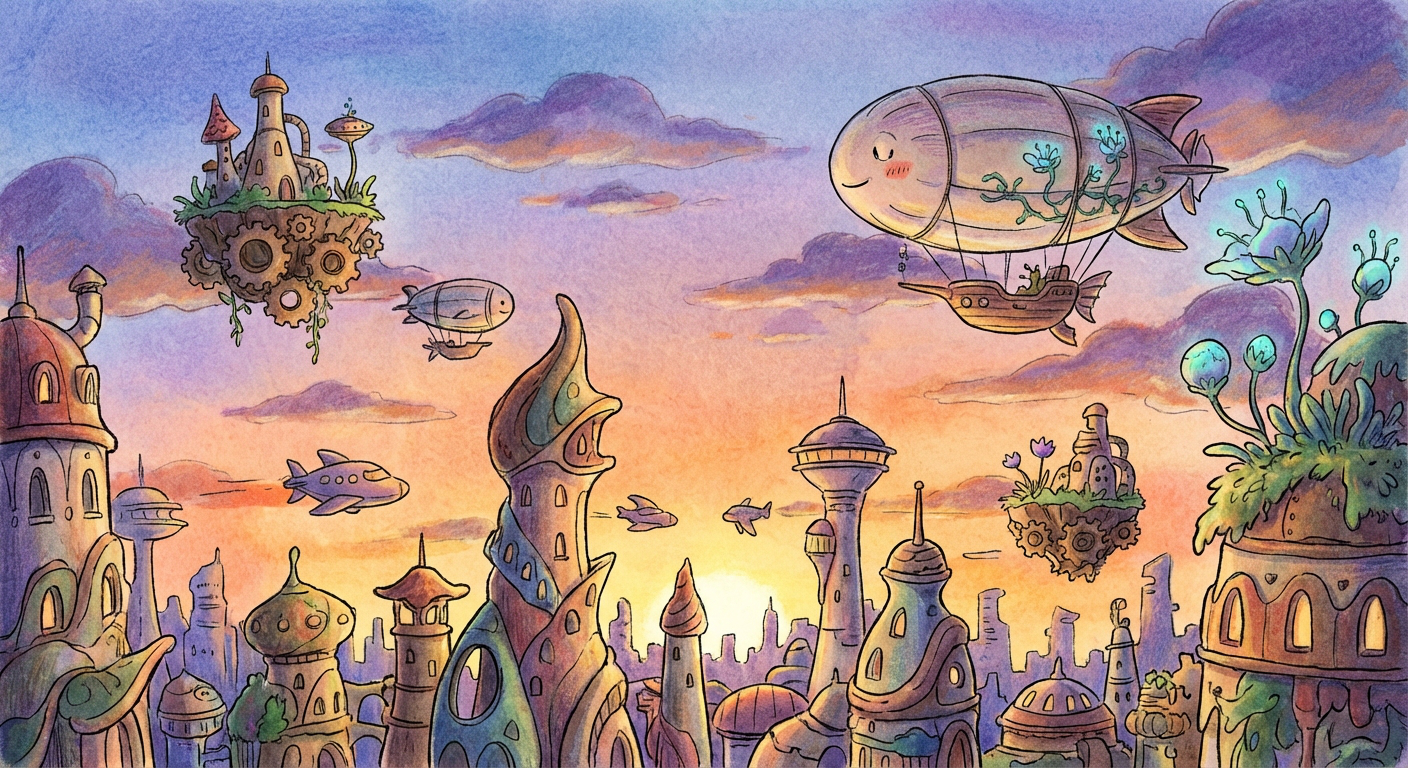

In [ ]:
from PIL import Image

Image.open("gemini.jpg")


## 15. Resources and Next Steps

### Official Documentation

1. **Gemini API – Official Docs**  
   https://ai.google.dev/gemini-api/docs

2. **Gemini 3 Models Overview**  
   https://ai.google.dev/gemini-api/docs/gemini-3

3. **Gemini API Reference (REST & SDKs)**  
   https://ai.google.dev/api

4. **Official Python SDK (`google-genai`) Docs**  
   https://googleapis.github.io/python-genai/

5. **Google Gemini Cookbook (Examples)**  
   https://github.com/google-gemini/cookbook


### Community

- **Google AI Developer Forum**: https://discuss.ai.google.dev/
